## Predicting exons with Evo 2 Embeddings

As a result of extensive pretraining, we expect Evo 2 embeddings to capture details of eukaryotic gene architecture. By training a lightweight model on top of Evo 2 embeddings, we can build classifiers to predict genomic annotations. Annotation prediction tools, in combination with bioinformatic approaches, may aid in characterization of non-reference organism genomes. We demonstrate this approach by training a classifier to predict exonic annotation of a genomic position at single-nucleotide resolution. 

Here, we start by loading sample positions. We then extract Evo 2 embeddings for sample positions from diverse eukaryotes, run them through the exon classifier, and demonstrate classification accuracy.

In [1]:
# %%
import os
import io
import time
import base64
import json
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import zipfile

# Optional: metrics/plots
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

import torch

positions = pd.read_csv('samplePositions.tsv', sep='\t')

# only look at the first 25 rows
positions = positions[:25]
positions

,organism,assembly,gene_name,sequence_record,strand,position,label,forward_seq,reverse_seq
0,Homo_sapiens,GCF_000001405.40,CLCN7,NC_000016.10,-,1453979.0,0.0,atcactttgcttgtgtcttaccaaagatctttgcatccgtggttgt...,ggaagacctgccttcccagccagtgtccacagggcagcaattccac...
1,Homo_sapiens,GCF_000001405.40,PRORP,NC_000014.9,+,35275559.0,1.0,gtcagagggttgtgaatggggtggtcaggaacagcctttctgaggg...,tacaaaaaataaattaaccaggtgtggtggtgtccaccttataggg...
2,Homo_sapiens,GCF_000001405.40,ZNF804B,NC_000007.14,+,88969116.0,0.0,ttccttctgaatccaccaatgattttgtcattgacaaataaccttg...,aaactattcaaaaaaaaaaatagaggatgaaggaatacttccaaac...
3,Homo_sapiens,GCF_000001405.40,VPS8,NC_000003.12,+,184850021.0,1.0,tcagccaagttcattgaggaatgctgaatcctgtataagtgtattt...,cagtcatccttataatttgcttcttccccttctgctccaaggtaac...
4,Homo_sapiens,GCF_000001405.40,GOLGB1,NC_000003.12,-,121729928.0,1.0,ttcattaaaagttaaccaaagaaaatatgatctctaaagttgaaaa...,gggaagaagaatgtcacatactggtgccatttaacataaaatcaca...
5,Homo_sapiens,GCF_000001405.40,GRIK4,NC_000011.10,+,120959614.0,0.0,ttggcaaagggagttcccttttgtgtttctgggaaacccagtgtaa...,aacagatcacacagggtcctgaattttattcccagtgggatgggaa...
6,Homo_sapiens,GCF_000001405.40,FAN1,NT_187660.1,+,3228758.0,1.0,atatatcttcccttccagcctttgtggtgttttcatatattttact...,tttggtaggaataaacggtgatgtaaaaatctttcagttaagcaaa...
7,Homo_sapiens,GCF_000001405.40,JAZF1,NC_000007.14,-,28170697.0,0.0,tcagaggaaaatgctgttgagtaattgtccaggttttgaaactttt...,agtgaccgctccttgggatcagtgacttaagctgaaacatttacaa...
8,Homo_sapiens,GCF_000001405.40,GPR75-ASB3,NC_000002.12,-,53716629.0,1.0,aagcgttcccctttgtctgcaacctctctagcatctgttgtttttt...,tttatagcaatgcaagaacgaactaatacagaaaattggcactgaa...
9,Homo_sapiens,GCF_000001405.40,PRKACA,NC_000019.10,-,14092365.0,1.0,gggaggccaaggtgggcagatcacctgaggtcaggagtttgagacc...,attgcttgaggccaggagttccagacaagcctaggcaacatagcaa...


In [2]:

NVIDIA_API_KEY = os.getenv("NVCF_RUN_KEY") or os.getenv("NVIDIA_API_KEY")
BASE_URL = "https://health.api.nvidia.com/v1/biology"

if NVIDIA_API_KEY is None:
    raise RuntimeError(
        "Missing NVIDIA API key. Set env var NVCF_RUN_KEY or NVIDIA_API_KEY."
    )

HEADERS = {
    "Authorization": f"Bearer {NVIDIA_API_KEY}",
    "Content-Type": "application/json",
}

MODEL_NAME = "evo2-7b"          # adjust if you’re using a different arc/model key
LAYER_NAME = "blocks.26"        # the hidden layer to pull token embeddings from
TIMEOUT_S  = 300

In [3]:
def evo2_forward(sequence, output_layers=None, model="evo2-7b", timeout_s=1800, max_polls=120):
    print(f"Using model: {model} to forward")

    if output_layers is None:
        output_layers = ["unembed"]
    elif "unembed" not in output_layers:
        output_layers = ["unembed"] + list(output_layers)

    url = f"{BASE_URL}/arc/{model}/forward"
    payload = {"sequence": sequence, "output_layers": output_layers}

    headers = dict(HEADERS)
    headers.setdefault("Accept", "application/json, application/zip")
    # reduce polling by asking server to hold the connection (if supported)
    headers.setdefault("Prefer", "wait=30")

    # 1) Kick off
    r = requests.post(url, headers=headers, json=payload, timeout=timeout_s)
    print("Received response, status code:", r.status_code)

    # 2) Poll loop for 202 (POST, not GET)
    polls = 0
    reqid = r.headers.get("Nvcf-Reqid")
    while r.status_code == 202:
        polls += 1
        retry_after = int(r.headers.get("Retry-After", 10))
        status_hdr  = r.headers.get("Nvcf-Status")
        print(f"[poll {polls}] 202 Accepted — status={status_hdr}, retry_after={retry_after}s, reqid={reqid}")
        if polls >= max_polls:
            raise TimeoutError(f"Gave up after {polls} polls (last status={status_hdr}).")

        time.sleep(retry_after)

        poll_headers = dict(headers)
        if reqid:
            poll_headers["Nvcf-Reqid"] = reqid

        # Many backends require the SAME payload when polling. Try with payload first.
        r = requests.post(url, headers=poll_headers, json=payload, timeout=timeout_s)
        print("Poll response code:", r.status_code)

        if r.status_code == 405:
            # If the server responds with 405 again, surface allowed methods for debugging
            allow = r.headers.get("Allow")
            raise RuntimeError(f"Polling method not allowed (405). Server Allow={allow}. "
                            f"Keep using POST to /forward with the SAME payload.")

        # Some backends might redirect to a result URL; follow Location if present
        if r.status_code in (303, 302) and "Location" in r.headers:
            url = r.headers["Location"]
            # Usually result endpoints accept GET:
            r = requests.get(url, headers=poll_headers, timeout=timeout_s)
            print("Followed Location, response:", r.status_code)

    # 3) Non-202 → decode
    r.raise_for_status()
    ct = (r.headers.get("Content-Type") or "").lower()
    print("Final Content-Type:", ct)

    def squeeze(x: np.ndarray) -> np.ndarray:
        return x[0] if (isinstance(x, np.ndarray) and x.ndim >= 3 and x.shape[0] == 1) else x

    if "application/zip" in ct or "application/x-zip" in ct or "application/octet-stream" in ct:
        # Outer ZIP → inner JSON → base64 NPZ
        with zipfile.ZipFile(io.BytesIO(r.content), "r") as z:
            names = z.namelist()
            if not names:
                raise RuntimeError("Empty ZIP in response.")
            inner = z.read(names[0])
        resp = json.loads(inner.decode("utf-8", "replace"))
        if "data" not in resp:
            raise RuntimeError(f"Inner JSON missing 'data'; keys={list(resp.keys())}")
        raw = base64.b64decode(resp["data"])
        npz = np.load(io.BytesIO(raw), allow_pickle=False)
        tensors = {k: npz[k] for k in npz.files}

    elif "application/json" in ct:
        resp = r.json()
        if "data" not in resp:
            raise RuntimeError(f"JSON missing 'data'; keys={list(resp.keys())}")
        raw = base64.b64decode(resp["data"])
        npz = np.load(io.BytesIO(raw), allow_pickle=False)
        tensors = {k: npz[k] for k in npz.files}

    else:
        snippet = r.content[:200]
        raise RuntimeError(f"Unsupported Content-Type: {ct}. First 200 bytes: {snippet!r}")

    logits = tensors.pop("unembed", None)
    if logits is not None:
        logits = squeeze(logits)
    acts = {k: squeeze(v) for k, v in tensors.items()}

    print(f"Got {len(acts)} activation layers: {list(acts.keys())}")
    if logits is not None:
        print("Logits shape:", logits.shape)

    return logits, acts

example_seq_short = 'TCTGAAAGGACAGTTTTATTGTAGGTACACATGGCTGCCATTTCAAATGTAACTCACAGCTTGTCCATCAGTCCTTG'
logits, short_acts = evo2_forward(example_seq_short, output_layers=["blocks.26.mlp.l3"])
print(short_acts["blocks.26.mlp.l3.output"].shape)

Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/json
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
(77, 4096)


In [4]:
# %%
def last_token_embedding_from_layer(sequence, layer_name):
    """
    Fetch embeddings from Evo2 API and return last-token vector from the requested layer.
    Assumes returned tensor has shape [batch=1, T, hidden_dim] or [T, hidden_dim].
    """
    logits, acts = evo2_forward(sequence, output_layers=[layer_name])
    arr = acts[f'{layer_name}.output']
    print(arr.shape)
    # Shape normalization
    if arr.ndim == 3:   # [1, T, H]
        return arr[0, -1, :].astype(np.float32)
    elif arr.ndim == 2: # [T, H]
        return arr[-1, :].astype(np.float32)
    else:
        raise ValueError(f"Unexpected array shape for {layer_name}: {arr.shape}")
    

last_token_embedding_from_layer(example_seq_short, 'blocks.26.mlp.l3')

Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/json
Got 2 activation layers: ['blocks.26.mlp.l3.output', 'unembed.output']
(77, 4096)


array([ 0.03735352,  0.04663086, -0.01867676, ..., -0.01672363,
       -0.1484375 , -0.09326172], shape=(4096,), dtype=float32)

In [5]:
# Get Evo 2 embeddings for the each position and append to the dataframe
embedding_list = []
layer_name = 'blocks.26'

for index, row in tqdm(positions.iterrows(), total=len(positions), desc="Extracting embeddings"):
    print(f"Processing index {index} with sequences of length {len(row['forward_seq'])} and {len(row['reverse_seq'])}")
    emb_fwd = last_token_embedding_from_layer(row['forward_seq'], layer_name)
    emb_rev = last_token_embedding_from_layer(row['reverse_seq'], layer_name)
    emb_concat = np.concatenate((emb_fwd, emb_rev))
    embedding_list.append(emb_concat)

# Add to DataFrame
positions['embedding'] = embedding_list

Extracting embeddings:   0%|          | 0/25 [00:00<?, ?it/s]

Processing index 0 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:   4%|▍         | 1/25 [01:12<28:50, 72.11s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 1 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:   8%|▊         | 2/25 [02:24<27:37, 72.07s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 2 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  12%|█▏        | 3/25 [03:35<26:18, 71.73s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 3 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  16%|█▌        | 4/25 [04:46<24:58, 71.37s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 4 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  20%|██        | 5/25 [05:58<23:52, 71.64s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 5 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  24%|██▍       | 6/25 [07:11<22:51, 72.17s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 6 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  28%|██▊       | 7/25 [08:21<21:26, 71.45s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 7 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  32%|███▏      | 8/25 [09:35<20:27, 72.20s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 8 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  36%|███▌      | 9/25 [10:50<19:31, 73.24s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 9 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  40%|████      | 10/25 [14:57<31:41, 126.78s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 10 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  44%|████▍     | 11/25 [16:06<25:26, 109.05s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 11 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  48%|████▊     | 12/25 [17:19<21:14, 98.02s/it] 

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 12 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  52%|█████▏    | 13/25 [18:31<18:00, 90.07s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 13 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  56%|█████▌    | 14/25 [19:40<15:22, 83.87s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 14 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  60%|██████    | 15/25 [20:51<13:21, 80.11s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 15 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  64%|██████▍   | 16/25 [22:02<11:35, 77.24s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 16 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  68%|██████▊   | 17/25 [23:12<09:59, 75.00s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 17 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  72%|███████▏  | 18/25 [24:23<08:36, 73.78s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 18 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  76%|███████▌  | 19/25 [25:33<07:16, 72.68s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 19 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  80%|████████  | 20/25 [26:42<05:57, 71.57s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 20 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  84%|████████▍ | 21/25 [27:51<04:43, 70.86s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 21 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  88%|████████▊ | 22/25 [29:01<03:31, 70.62s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 22 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  92%|█████████▏| 23/25 [30:12<02:21, 70.60s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 23 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings:  96%|█████████▌| 24/25 [31:25<01:11, 71.34s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Processing index 24 with sequences of length 8192 and 8192
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip
Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)
Using model: evo2-7b to forward
Received response, status code: 200
Final Content-Type: application/zip


Extracting embeddings: 100%|██████████| 25/25 [32:34<00:00, 78.19s/it]

Got 2 activation layers: ['blocks.26.output', 'unembed.output']
(8192, 4096)


In [8]:
# Load the lightweight exon classifier
from transformers import AutoModel

exon_classifier = AutoModel.from_pretrained(
    "schmojo/evo2-exon-classifier",
    trust_remote_code=True   # pulls the two .py files
).to('mps')

/Users/garrettroell/yarrowia_genome_language_modeling/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Generate exonic probabilities for each sample position
exonic_probs_list = []

for _, row in tqdm(positions.iterrows(), total=len(positions), desc="Calculating exonic probabilities"):
    embedding_tensor = torch.tensor(row['embedding'], dtype=torch.float32).unsqueeze(0).unsqueeze(1).to('mps')
    prob = exon_classifier(embedding_tensor)
    prob_value = prob['logits'].item()
    exonic_probs_list.append(prob_value)

# Add to DataFrame
positions['exon_prob'] = exonic_probs_list

Calculating exonic probabilities: 100%|██████████| 25/25 [00:01<00:00, 22.26it/s]


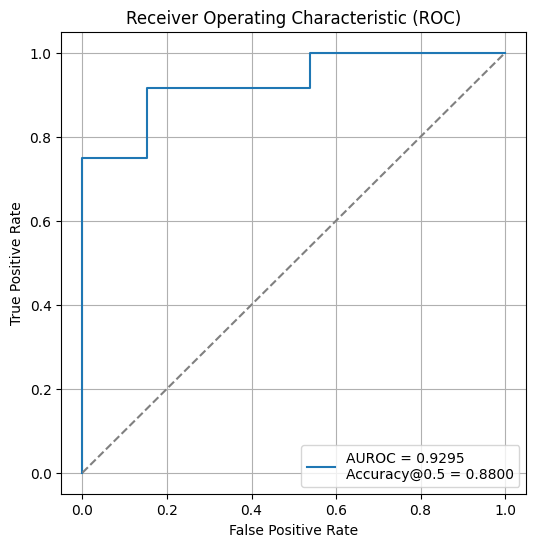

In [10]:
# Plot ROC and display Accuracy (threshold=0.5) and AUROC
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt

y_true = positions['label']
y_scores = positions['exon_prob']

# AUROC
auroc = roc_auc_score(y_true, y_scores)

# Accuracy at threshold 0.5
y_pred = (y_scores >= 0.5).astype(int)
accuracy = accuracy_score(y_true, y_pred)

# ROC curve
fpr, tpr, _ = roc_curve(y_true, y_scores)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}\nAccuracy@0.5 = {accuracy:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()